In [1]:
% pylab inline
import os
import random

import pandas as pd
from scipy.misc import imread
from sklearn.metrics import accuracy_score

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Convolution2D, Flatten, MaxPooling2D, Reshape, InputLayer

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
pwd

'C:\\Users\\sumit\\Documents\\ADS\\Ass 2\\IMFDB'

In [3]:
data_dir = %pwd

In [4]:
# setting working directory
data_dir = data_dir+ '/data/'

In [5]:
data_dir

'C:\\Users\\sumit\\Documents\\ADS\\Ass 2\\IMFDB/data/'

In [6]:
root_dir = os.path.abspath('C:/Users/sumit/Documents/ADS/Ass 2/IMFDB')
 

In [7]:
 data_dir = 'C:/Users/sumit/Documents/ADS/Ass 2/IMFDB/data'

In [8]:
train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test  = pd.read_csv(os.path.join(data_dir, 'test.csv'))

Age:  MIDDLE


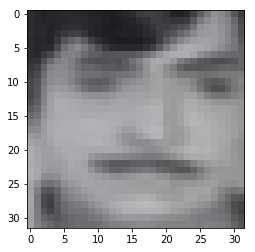

In [9]:
# Randomly choosing an image and printing it
i = random.choice(train.index)

img_name = train.ID[i]
img = imread(os.path.join(data_dir, 'Train', img_name))


imshow(img)
print('Age: ', train.Class[i])

In order to counter variations in shape, quality etc lets resize the image for uniformity:

Lets resize the images into a single numpy array:

In [10]:
from scipy.misc import imresize

temp = []
for img_name in train.ID:
    img_path = os.path.join(data_dir, 'Train', img_name)
    img = imread(img_path)
    img = imresize(img, (32, 32))
    img = img.astype('float32')
    temp.append(img)

train_x = np.stack(temp)


In [11]:
# similarly resizing the test images

temp = []
for img_name in test.ID:
    img_path = os.path.join(data_dir, 'Test', img_name)
    img = imread(img_path)
    img = imresize(img, (32, 32))
    img = img.astype('float32') 
    temp.append(img)

test_x = np.stack(temp)


In [12]:
# Normalizing the Images to enhance model training
train_x = train_x/255.
test_x = test_x/255.

In [13]:
# Let us check the distribution of Class (target variable)
train.Class.value_counts(normalize=True)

MIDDLE    0.542751
YOUNG     0.336883
OLD       0.120366
Name: Class, dtype: float64

We see here that almost 54% of the Class is in the Middle Aged group which gives a good chance of picking up an image 
belonging to a middle age group actor.

Our initial exploration of the data is over and so we can now move to build our model

Since we have 3 categories in our Target variable, lets transform it into dummy variables:


In [14]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
train_y = label.fit_transform(train.Class)
train_y = keras.utils.np_utils.to_categorical(train_y)

Lets form the CNN model:

In [17]:
# We will use ReLU as activation function to remove negative pixel values in the feature map and have non-linearity in our CNN
input_units = (32,32,3)
hidden_num_units = 500
output_num_units = 3
epochs = 5
batch_size = 128

conv_num_filters = 5
conv_filter_size = 5

pool_size = (2, 2)


model = Sequential([
InputLayer(input_shape=input_units),
# We will use ReLU as activation function to remove negative pixel values in the feature map and have non-linearity in our CNN
Convolution2D(96, (3, 3), activation='relu'),
MaxPooling2D(pool_size=pool_size),

Convolution2D(256, (2, 2), activation='relu'),
MaxPooling2D(pool_size=pool_size),

Convolution2D(256, (2, 2), activation='relu'),
MaxPooling2D(pool_size=pool_size),
        
Convolution2D(384, (2, 2), activation='relu'),
MaxPooling2D(pool_size=pool_size),    

Flatten(),
Dense(units=1536, activation='relu'),
Dense(units=output_num_units, activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 96)        2688      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 96)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 256)       98560     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 6, 6, 256)         262400    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 3, 256)         0         
__________

In [18]:
# Fitting the model
model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/5
19906/19906 [==============================] - 188s - loss: 0.9985 - acc: 0.5331   
Epoch 2/5
19906/19906 [==============================] - 189s - loss: 0.9476 - acc: 0.5428   
Epoch 3/5
19906/19906 [==============================] - 228s - loss: 0.9458 - acc: 0.5428   
Epoch 4/5
19906/19906 [==============================] - 239s - loss: 0.9447 - acc: 0.5428   
Epoch 5/5
19906/19906 [==============================] - 219s - loss: 0.9435 - acc: 0.5428   


In [43]:
sample_submission = pd.read_csv(os.path.join(data_dir, 'Sample_Submission.csv'))


In [44]:
# predicting the test set 
test_x_temp = test_x.reshape(-3, 32, 32, 3)
pred = model.predict_classes(test_x_temp)

pred.shape

6624/6636 [============================>.] - ETA: 0s

(6636,)

In [45]:
# Inverting to original classes
pred_f = label.inverse_transform(pred)



In [49]:
sample_submission.ID = test.ID
sample_submission.Class = pred_f


In [51]:
# Predicted test set
sample_submission

,Class,ID
0,MIDDLE,25321.jpg
1,MIDDLE,989.jpg
2,MIDDLE,19277.jpg
3,MIDDLE,13093.jpg
4,MIDDLE,5367.jpg
5,MIDDLE,19851.jpg
6,MIDDLE,10384.jpg
7,MIDDLE,24567.jpg
8,MIDDLE,2029.jpg
9,MIDDLE,4956.jpg
